In [28]:
from imp import reload
from nltk.corpus import stopwords
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib as mpl
import nltk,re,pprint
import sys,glob,os
import operator, string, argparse, math, random
import matplotlib.pyplot as plot

Matplotlib is building the font cache; this may take a moment.


In [56]:
class flingDBSCAN:
    def __init__(self,data,nthres):
        self.data = data
        self.near_threshold = nthres
        self.nDocs = len(self.data)
        self.allDistances = {}
        self.wordVecModel = None
        print("\nDBSCAN initialized!\n")
        
    def loadPretrainedWordVectors(self,vecType):
        if vecType == 'glove':
            self.wordVecModel = self.loadGloveModel()
            print("GloVe Vectors Loaded!\n")

    def loadGloveModel(self):
        print("Loading Glove Model\n")
        f = open('../datasets/glove.6B/glove.6B.50d.txt','r')
        gloveModel = {}
        for line in f:
            splitLines = line.split()
            word = splitLines[0]
            wordEmbedding = np.array([float(value) for value in splitLines[1:]])
            gloveModel[word] = wordEmbedding
        print(len(gloveModel)," words loaded!\n")
        return gloveModel    

    # distance between two documents using TF-IDF
    def distanceBtnTwoDocs(self, docId_1, docId_2):
        listWords_1 = set(list(self.data['tfMatrix'][int(docId_1)]['word']))
        listWords_2 = set(list(self.data['tfMatrix'][int(docId_2)]['word']))
        common = listWords_1.intersection(listWords_2)
        diff1_2 = listWords_1.difference(listWords_2)
        diff2_1 = listWords_2.difference(listWords_1)
        sumwt1 = self.data['sumTFIDF'][docId_1]
        sumwt2 = self.data['sumTFIDF'][docId_2]
        score_common, score_doc1, score_doc2 = 0,0,0
        #print(len(common),len(diff1_2),len(diff2_1))
        for word_c in common:
            score_1 = float(self.data['tfMatrix'][docId_1].loc[self.data['tfMatrix'][docId_1]['word'] == word_c]['tf-idf'])
            score_2 = float(self.data['tfMatrix'][docId_2].loc[self.data['tfMatrix'][docId_2]['word'] == word_c]['tf-idf'])
            score_common += abs(score_1/float(sumwt1) - score_2/float(sumwt2))
        for word_d12 in diff1_2:
            score_1 = float(self.data['tfMatrix'][docId_1].loc[self.data['tfMatrix'][docId_1]['word'] == word_d12]['tf-idf'])
            score_doc1 += score_1/float(sumwt1)
        for word_d21 in diff2_1:
            score_2 = float(self.data['tfMatrix'][docId_2].loc[self.data['tfMatrix'][docId_2]['word'] == word_d21]['tf-idf'])
            score_doc2 += score_2/float(sumwt2)
        score_total = score_common + score_doc1 + score_doc2
        return(score_total)
    
    def getGloveVectorList(self,listx):
        vecList = []
        nf = []
        for w in listx:
            try:
                vecList.append(self.wordVecModel[w])
            except:
                nf.append(w)
                #print(w,"not found in glove model!")
                continue
        vecArray = np.stack(vecList, axis=0 )
        return vecArray
    
    def getDocVector(self,listx):
        gvl=self.getGloveVectorList(listx)
        glove_dv = np.mean(gvl,axis=0)
        return(glove_dv)
    
    def getGloveDistance(self,docId_1,docId_2,method):
        listWords_1 = set(list(self.data['tfMatrix'][int(docId_1)]['word']))
        listWords_2 = set(list(self.data['tfMatrix'][int(docId_2)]['word']))
        if method == 'average':
            dv_1 = self.getDocVector(listWords_1)
            dv_2 = self.getDocVector(listWords_2)
            #print("dv_1",dv_1)
            #print("dv_2",dv_2)
            dist = np.linalg.norm(dv_1-dv_2)
            return dist
            
    def findNear(self,docId):
        nearList = {}
        for el in range(self.nDocs):
            if docId!=el:
                dist = self.distanceBtnTwoDocs(int(docId),int(el))
                print("el",dist)
                if dist<self.near_threshold:
                    if [docId,el].sort() not in self.allDistances:
                        print([docId,el].sort()," w.distance:",dist)
                        self.allDistances[[docId,el].sort()]=dist
                    nearList[el]=dist
        print(nearList)
              
    def drawProgressBar(self, percent, barLen = 50):			#just a progress bar so that you dont lose patience
        sys.stdout.write("\r")
        progress = ""
        for i in range(barLen):
            if i<int(barLen * percent):
                progress += "="
            else:
                progress += " "
        sys.stdout.write("[ %s ] %.2f%%" % (progress, percent * 100))
        sys.stdout.flush()	

    #sample distance between n random documents 
    def getDistanceDistribution(self,numx):
        numHalf = int(numx/2)
        doca,docb = [],[]
        for i in range(numHalf):
            doca.append(random.randint(1,1026))
            docb.append(random.randint(1027,2053))
        distanceSample = []
        total = numHalf*numHalf
        for doc_1 in range(len(doca)):
            for doc_2 in range(len(docb)):
                distanceSample.append(self.getGloveDistance(doca[doc_1],docb[doc_2],'average'))
                cov = doc_1*numHalf + doc_2
                prog=(cov+1)/total
                self.drawProgressBar(prog)
        pltx = plot.hist(distanceSample,bins=20)
        return(pltx)

In [57]:
dataProcessed = pd.read_pickle('../processFiles/data_tfidf_processed.pkl')
fdb = flingDBSCAN(dataProcessed,1.5)
fdb.loadPretrainedWordVectors('glove')


DBSCAN initialized!

Loading Glove Model

400000  words loaded!

GloVe Vectors Loaded!



[ ================================================== ] 100.00%

(array([1., 0., 3., 3., 3., 3., 2., 8., 1., 3., 2., 1., 0., 0., 0., 1., 0.,
        3., 0., 2.]),
 array([0.32430842, 0.37069877, 0.41708911, 0.46347946, 0.5098698 ,
        0.55626015, 0.60265049, 0.64904084, 0.69543118, 0.74182152,
        0.78821187, 0.83460221, 0.88099256, 0.9273829 , 0.97377325,
        1.02016359, 1.06655394, 1.11294428, 1.15933463, 1.20572497,
        1.25211532]),
 <BarContainer object of 20 artists>)

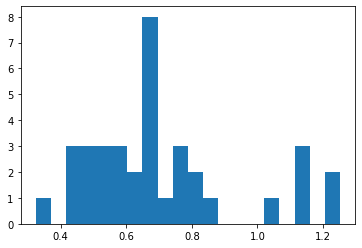

In [59]:
#get distributions for different number of documents
fdb.getDistanceDistribution(12)

[ ================================================== ] 100.00%

(array([  2.,   0.,  27., 195., 430., 455., 403., 395., 266., 134.,  67.,
         42.,  20.,  12.,   9.,  10.,  21.,   8.,   1.,   3.]),
 array([0.08832741, 0.18676094, 0.28519447, 0.383628  , 0.48206153,
        0.58049506, 0.67892858, 0.77736211, 0.87579564, 0.97422917,
        1.0726627 , 1.17109623, 1.26952975, 1.36796328, 1.46639681,
        1.56483034, 1.66326387, 1.7616974 , 1.86013092, 1.95856445,
        2.05699798]),
 <BarContainer object of 20 artists>)

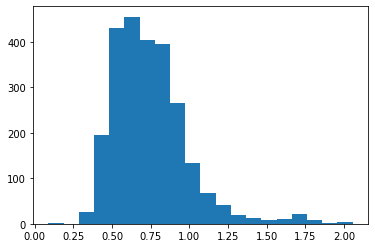

In [60]:
fdb.getDistanceDistribution(100)

In [ ]:
fdb.getDistanceDistribution(200)